In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import re
import contractions

from nltk.corpus import stopwords
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from nltk import sent_tokenize
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn import metrics
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

In [2]:
df = pd.read_csv('../data/political_subreddit.csv')

### XGBoost

In [3]:
def custom_preprocessor(text):
    text = contractions.fix(text.lower())                   # fix contractions and lowercase
    text = re.sub(r'^>.*$', '', text, flags=re.MULTILINE)   # remove quotes
    text = re.sub(r'http\S+|www\S+', '', text)              # remove URLs
    text = re.sub(r'@\w+', '', text)                        # remove mentions
    text = re.sub(r'[^a-z\s]', '', text)                    # remove punctuation/numbers
    text = re.sub(r'\s+', ' ', text).strip()                # clean extra whitespace
    return text

In [4]:
tfidf_vectorizer = TfidfVectorizer(
    preprocessor=custom_preprocessor,
    stop_words='english',
    max_features=2000
)

In [5]:
X = df[['text']]
y = df['political_alignment']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [6]:
tfidf_vectorizer = TfidfVectorizer(
    preprocessor=custom_preprocessor,
    stop_words='english',
    max_features= 1000
)

In [7]:
preprocessing_tfidf = ColumnTransformer([
    ('text', tfidf_vectorizer, 'text')
])

In [8]:
pipeline = Pipeline([
    ('features', preprocessing_tfidf),
    ('model', GradientBoostingClassifier())
])

In [9]:
param_grid = {
    'model__n_estimators': [200],    
    'model__learning_rate': [0.01],       
    'model__max_depth': [10, 15],                   
    'features__text__min_df': [10],
    'features__text__ngram_range': [(1,1), (1,2), (1,3)]
}

In [10]:
grid = GridSearchCV(
    estimator=pipeline,
    param_grid=param_grid,
    cv=5,
    scoring='accuracy', 
    n_jobs=-1,
    verbose=2
)

grid.fit(X_train[['text']], y_train) 

Fitting 5 folds for each of 6 candidates, totalling 30 fits


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('features',
                                        ColumnTransformer(transformers=[('text',
                                                                         TfidfVectorizer(max_features=1000,
                                                                                         preprocessor=<function custom_preprocessor at 0x000002087E6BF100>,
                                                                                         stop_words='english'),
                                                                         'text')])),
                                       ('model',
                                        GradientBoostingClassifier())]),
             n_jobs=-1,
             param_grid={'features__text__min_df': [10],
                         'features__text__ngram_range': [(1, 1), (1, 2),
                                                         (1, 3)],
                         'model__learning_rate': [0.01],
                         'model__max_depth': [10, 15],
                         'model__n_estimators': [200]},
             scoring='accuracy', verbose=2)

In [11]:
print("Best Params:", grid.best_params_)
print("Best Cross-Validated Accuracy:", grid.best_score_)

Best Params: {'features__text__min_df': 10, 'features__text__ngram_range': (1, 1), 'model__learning_rate': 0.01, 'model__max_depth': 10, 'model__n_estimators': 200}
Best Cross-Validated Accuracy: 0.6012353851037818


In [12]:
y_pred = grid.predict(X_test[['text']])

In [13]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.62      0.88      0.73       693
           1       0.57      0.22      0.32       485

    accuracy                           0.61      1178
   macro avg       0.60      0.55      0.52      1178
weighted avg       0.60      0.61      0.56      1178



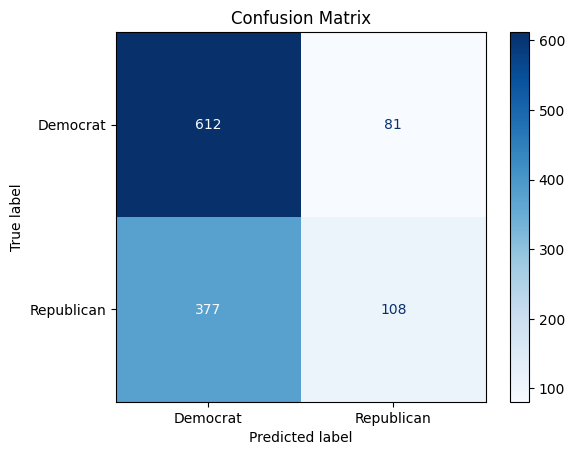

In [14]:
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Democrat', 'Republican'])
disp.plot(cmap='Blues')
plt.title("Confusion Matrix")
plt.show()